# Multi-Label Quality Classification via Res2Net

In [ ]:
import os
import glob
import json
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
import tensorflow as tf
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score, hamming_loss
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, hamming_loss
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import multilabel_confusion_matrix, roc_curve, auc, classification_report

## Loading and Preprocessing Data

**Dataset Loading:**  
The dataset is loaded by reading all `.wav` audio files from a specified directory and parsing their corresponding metadata from a JSON file. Each audio file is matched with its label information, which contains a list of descriptive timbre qualities. These qualities are then encoded into a binary multi-label format based on a predefined class list.

**Data Processing:**  
Each audio file is segmented into overlapping 1-second windows, and for each segment, log-Mel spectrograms are extracted along with their delta features to capture both spectral content and temporal variation. These are stacked into 2-channel input tensors. If an audio file is shorter than the target duration, it is zero-padded; if longer, it is truncated. All resulting segments are converted to `float32` for efficiency and paired with their corresponding labels before being split into training, validation, and test sets.

**Why use audio segments instead of full recordings?**

Segmenting audio into short overlapping chunks (e.g., 1-second segments) helps increase the number of training samples and captures local timbre variations more effectively. Whole-audio prediction often performs poorly because it loses fine-grained temporal details and struggles with multi-label timbre detection. Segment-based models learn more robust and generalizable patterns.

In [ ]:
# ========== Path and parameter settings ==========
AUDIO_DIR = "../data/audio"
JSON_PATH = "../data/examples.json"

SAMPLE_RATE = 16000
N_MELS = 96
WINDOW_SIZE_SEC = 1.0
HOP_RATIO = 0.5
MAX_DURATION = 4.0
FRAME_TRIM = 96

quality_classes = [
    'bright', 'dark', 'distortion', 'fast_decay', 'long_release',
    'multiphonic', 'nonlinear_env', 'percussive', 'reverb'
]

# ========== Label encoding function ==========
def encode_labels(qualities_str, class_list):
    label = [0] * len(class_list)
    for q in qualities_str:
        if q in class_list:
            label[class_list.index(q)] = 1
    return label

# ========== Feature extraction function ==========
def extract_logmel_delta(path):
    try:
        y, _ = librosa.load(path, sr=SAMPLE_RATE)
        target_len = int(SAMPLE_RATE * MAX_DURATION)
        if len(y) < target_len:
            y = np.pad(y, (0, target_len - len(y)))
        else:
            y = y[:target_len]

        win_len = int(WINDOW_SIZE_SEC * SAMPLE_RATE)
        hop_len = int(win_len * HOP_RATIO)

        segments = []
        for start in range(0, len(y) - win_len + 1, hop_len):
            seg = y[start:start + win_len]
            mel = librosa.feature.melspectrogram(
                y=seg, sr=SAMPLE_RATE, n_mels=N_MELS, n_fft=512, hop_length=256
            )
            logmel = librosa.power_to_db(mel, ref=np.max)
            logmel = logmel[:, :FRAME_TRIM]
            delta = librosa.feature.delta(logmel)
            stacked = np.stack([logmel, delta], axis=-1)
            segments.append(stacked)
        return np.array(segments)
    except Exception as e:
        print(f"Error processing {path}: {e}")
        return None

# ========== Main pipeline ==========
X = []
Y = []

with open(JSON_PATH, "r") as f:
    metadata = json.load(f)

file_paths = sorted(glob.glob(os.path.join(AUDIO_DIR, "*.wav")))

for path in file_paths:
    basename = os.path.splitext(os.path.basename(path))[0]
    if basename not in metadata:
        print(f"Warning: {basename} not in metadata.")
        continue

    entry = metadata[basename]
    label = encode_labels(entry["qualities_str"], quality_classes)
    features = extract_logmel_delta(path)

    if features is not None and len(features) > 0:
        for segment in features:
            X.append(segment.astype(np.float32))  # Convert to float32 to save memory
            Y.append(np.array(label, dtype=np.float32))  # Multi-label
    else:
        print(f"Skipped: {basename}")

X = np.array(X)
Y = np.array(Y)
print("Total segments:", len(X))

# ========== Split Train / Val / Test ==========
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test   = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Train:", X_train.shape)
print("Val  :", X_val.shape)
print("Test :", X_test.shape)

Total segments: 28672
Train: (22937, 96, 63, 2)
Val  : (2867, 96, 63, 2)
Test : (2868, 96, 63, 2)


## Building the Model

This Res2Net model is a deep convolutional architecture specifically adapted for audio feature inputs shaped (96, 63, 2), where 2 represents stacked log-Mel and delta features. The model design follows several key principles tailored for temporal and spectral feature learning in audio-based multi-label classification. Here's a breakdown of its design principles:

1. Deep Residual Learning with Res2Net Blocks

- Uses the Bottle2neck structure from Res2Net, which extends traditional ResNet by allowing multi-scale feature extraction within each residual block.

- Each block splits channels into groups and processes them in parallel with different receptive fields (via convolution and residual fusion), improving capacity to model fine-grained acoustic patterns.

2. Progressive Downsampling with Channel Expansion

    Input passes through:

    - A 7x7 convolution (stride=3) and a max pooling layer (stride=2) to quickly reduce spatial size.

    - Four residual layers, each downsampling in time and frequency (stride=2) and expanding the number of channels.

    This design mimics how classical CNNs reduce dimensions while increasing depth, to build robust high-level representations.

3. Temporal Feature Aggregation

    After all spatial convolutions, the tensor shape is (B, C, F, T) — channels, frequency, time.

    The tensor is reshaped into (B, C×F, T) to collapse the frequency dimension into features.

    Then TemporalAveragePooling computes the mean over time, which:

    - Aggregates frame-level embeddings into an utterance-level embedding.

    - Ensures variable-length temporal input can be processed.

4. Embedding and Classification Head

    The time-aggregated vector passes through:

    - BatchNorm → Linear layer → BatchNorm again

    - Final fully connected layer maps the 192-dim embedding to the number of classes (e.g., 9 timbre qualities).

    This separation between embedding and classification allows the architecture to also support embedding extraction for downstream tasks like retrieval or contrastive learning.

5. Modular and Scalable

- The architecture is modular: depth (`layers`), base width (`base_width`), and scale (`scale`) are all configurable.

- Can be scaled up (e.g., deeper layers, higher resolution input) for larger tasks, or down for low-resource settings.

In [ ]:
class TemporalAveragePooling(nn.Module):
    def forward(self, x):  # x: (B, C, T)
        return torch.mean(x, dim=2)

class Bottle2neck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, baseWidth=26, scale=4, stype='normal'):
        super(Bottle2neck, self).__init__()
        width = int(math.floor(planes * (baseWidth / 64.0)))
        self.conv1 = nn.Conv2d(inplanes, width * scale, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width * scale)
        self.relu = nn.ReLU(inplace=True)

        self.nums = 1 if scale == 1 else scale - 1
        self.stype = stype
        self.scale = scale
        self.width = width

        if stype == 'stage':
            self.pool = nn.AvgPool2d(kernel_size=3, stride=stride, padding=1)

        self.convs = nn.ModuleList([
            nn.Conv2d(width, width, kernel_size=3, stride=stride, padding=1, bias=False)
            for _ in range(self.nums)
        ])
        self.bns = nn.ModuleList([
            nn.BatchNorm2d(width) for _ in range(self.nums)
        ])

        self.conv3 = nn.Conv2d(width * scale, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)

        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        spx = torch.split(out, self.width, 1)
        for i in range(self.nums):
            sp = spx[i] if i == 0 or self.stype == 'stage' else sp + spx[i]
            sp = self.convs[i](sp)
            sp = self.relu(self.bns[i](sp))
            out = sp if i == 0 else torch.cat((out, sp), 1)

        if self.scale != 1:
            sp_last = spx[self.nums]
            if self.stype == 'normal':
                out = torch.cat((out, sp_last), 1)
            elif self.stype == 'stage':
                out = torch.cat((out, self.pool(sp_last)), 1)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)
        return out

class Res2Net(nn.Module):
    def __init__(self, num_class, input_freq=63, input_time=96, in_channels=2,
                 m_channels=32, layers=[3, 4, 6, 3], base_width=32, scale=2,
                 embd_dim=192, pooling_type="TAP"):
        super(Res2Net, self).__init__()
        self.inplanes = m_channels
        self.base_width = base_width
        self.scale = scale

        self.conv1 = nn.Conv2d(in_channels, m_channels, kernel_size=7, stride=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(m_channels)
        self.relu = nn.ReLU(inplace=True)
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(Bottle2neck, m_channels, layers[0])
        self.layer2 = self._make_layer(Bottle2neck, m_channels * 2, layers[1], stride=2)
        self.layer3 = self._make_layer(Bottle2neck, m_channels * 4, layers[2], stride=2)
        self.layer4 = self._make_layer(Bottle2neck, m_channels * 8, layers[3], stride=2)

        # Downsample freq dimension
        down_freq = input_freq
        for _ in range(5):  # conv1(stride=3) + maxpool(stride=2) + 3 stride-2 layers
            down_freq = math.floor((down_freq + 1) / 2)

        self.final_channels = m_channels * 8 * Bottle2neck.expansion * down_freq

        self.pooling = TemporalAveragePooling()
        self.bn2 = nn.BatchNorm1d(self.final_channels)
        self.linear = nn.Linear(self.final_channels, embd_dim)
        self.bn3 = nn.BatchNorm1d(embd_dim)
        self.fc = nn.Linear(embd_dim, num_class)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = [block(self.inplanes, planes, stride, downsample, baseWidth=self.base_width, scale=self.scale, stype='stage')]
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, baseWidth=self.base_width, scale=self.scale))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = x.permute(0, 3, 2, 1)  # (B, 2, 63, 96)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        B, C, F, T = x.shape
        x = x.reshape(B, C * F, T)
        x = self.pooling(x)
        x = self.bn2(x)
        x = self.linear(x)
        x = self.bn3(x)
        out = self.fc(x)
        return out


In [ ]:
model = Res2Net(
    num_class=9,
    input_freq=63,
    input_time=96,
    in_channels=2,
    pooling_type="TAP"  
)

## Training the Model

This setup uses a batch size of 32 for efficient training, up to 100 epochs with early stopping (patience = 5) to prevent overfitting, and automatically selects GPU if available. Training and validation data are wrapped in TensorDataset and loaded with DataLoader for optimized mini-batch processing.

In [26]:
# Hyperparameters
batch_size = 32
epochs = 100
patience = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert to tensors and DataLoaders
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


In [27]:
# Move model to device
model.to(device)
criterion = nn.BCEWithLogitsLoss()  # For multi-label binary classification
optimizer = optim.Adam(model.parameters(), lr=1e-3)


This training loop uses early stopping to prevent overfitting and reduce unnecessary computation. It monitors the validation loss after each epoch:

If the validation loss improves, it resets the counter and saves the model state.

If there's no improvement for patience consecutive epochs (in this case, 5), training stops early.

After stopping, the model is restored to the state with the lowest validation loss.

This strategy ensures that the final model generalizes well without overtraining.

In [28]:
# Early stopping setup
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_train_loss = total_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item() * xb.size(0)
            all_preds.append(torch.sigmoid(preds).cpu().numpy())
            all_labels.append(yb.cpu().numpy())
    avg_val_loss = val_loss / len(val_loader.dataset)
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    pred_bin = (all_preds >= 0.5).astype(int)

    macro_f1 = f1_score(all_labels, pred_bin, average='macro')
    micro_f1 = f1_score(all_labels, pred_bin, average='micro')
    hamming = hamming_loss(all_labels, pred_bin)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f} - Macro F1: {macro_f1:.4f} - Micro F1: {micro_f1:.4f} - Hamming Loss: {hamming:.4f}")

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

# Restore best model
if best_model_state:
    model.load_state_dict(best_model_state)
    print("Restored best model from epoch with val loss:", best_val_loss)

Epoch 1/100 - Train Loss: 0.3224 - Val Loss: 0.2408 - Macro F1: 0.4991 - Micro F1: 0.5766 - Hamming Loss: 0.1042
Epoch 2/100 - Train Loss: 0.2124 - Val Loss: 0.2546 - Macro F1: 0.5659 - Micro F1: 0.5893 - Hamming Loss: 0.1056
Epoch 3/100 - Train Loss: 0.1758 - Val Loss: 0.1891 - Macro F1: 0.7304 - Micro F1: 0.7509 - Hamming Loss: 0.0688
Epoch 4/100 - Train Loss: 0.1492 - Val Loss: 0.2221 - Macro F1: 0.7144 - Micro F1: 0.7350 - Hamming Loss: 0.0740
Epoch 5/100 - Train Loss: 0.1337 - Val Loss: 0.1494 - Macro F1: 0.7575 - Micro F1: 0.7914 - Hamming Loss: 0.0562
Epoch 6/100 - Train Loss: 0.1249 - Val Loss: 0.1308 - Macro F1: 0.8007 - Micro F1: 0.8283 - Hamming Loss: 0.0486
Epoch 7/100 - Train Loss: 0.1101 - Val Loss: 0.1095 - Macro F1: 0.8179 - Micro F1: 0.8471 - Hamming Loss: 0.0431
Epoch 8/100 - Train Loss: 0.1046 - Val Loss: 0.1578 - Macro F1: 0.7679 - Micro F1: 0.7863 - Hamming Loss: 0.0583
Epoch 9/100 - Train Loss: 0.1010 - Val Loss: 0.1633 - Macro F1: 0.7705 - Micro F1: 0.7837 - Hamm

In [29]:
torch.save({
    'epoch': epoch,
    'model_state_dict': best_model_state,
    'optimizer_state_dict': optimizer.state_dict(),
    'val_loss': best_val_loss,
}, "quality_classification_Res2Net_model.pth")

## Evaluate the Model

In [31]:
def evaluate_model(model, X, y_true, threshold=0.5, batch_size=32, device='cuda'):
    model.eval()
    dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y_true, dtype=torch.float32))
    loader = DataLoader(dataset, batch_size=batch_size)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            preds = model(xb)
            preds = torch.sigmoid(preds).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(yb.numpy())

    y_pred_prob = np.vstack(all_preds)
    y_true_all = np.vstack(all_labels)

    y_pred_bin = (y_pred_prob >= threshold).astype(int)

    print("Subset Accuracy:", accuracy_score(y_true_all, y_pred_bin))
    print("Hamming Loss:", hamming_loss(y_true_all, y_pred_bin))
    print("Macro F1 Score:", f1_score(y_true_all, y_pred_bin, average='macro'))
    print("Micro F1 Score:", f1_score(y_true_all, y_pred_bin, average='micro'))

    return y_pred_bin, y_pred_prob

In [36]:
y_train_bin, y_train_prob = evaluate_model(model, X_train, y_train, device=device)
y_val_bin, y_val_prob = evaluate_model(model, X_val, y_val, device=device)

Subset Accuracy: 0.8597462614988882
Hamming Loss: 0.025417447791777476
Macro F1 Score: 0.8818863368238689
Micro F1 Score: 0.9097538742023701
Subset Accuracy: 0.8106034182071852
Hamming Loss: 0.03216680230980894
Macro F1 Score: 0.8574889241931912
Micro F1 Score: 0.8848821081830791


The model shows strong performance on both the training and validation sets. With a training subset accuracy of 86% and a macro F1 of 0.88, the model captures multi-label patterns effectively. Validation performance remains high (81% subset accuracy, 0.86 macro F1), indicating good generalization. Slight drops in validation metrics are expected and suggest minimal overfitting. Overall, the model is accurate, balanced across labels, and stable.

In [ ]:
y_pred_bin, y_pred_prob = evaluate_model(model, X_test, y_test, device=device)

Subset Accuracy: 0.7928870292887029
Hamming Loss: 0.03436386176971951
Macro F1 Score: 0.8482815059647607
Micro F1 Score: 0.875822483550329


The test results show strong generalization, with high F1 scores (Macro: 0.85, Micro: 0.88), low Hamming Loss (0.034), and solid Subset Accuracy (79.3%). The model performs reliably across labels and maintains good overall prediction quality on unseen data.

In [48]:
def plot_multilabel_confusion_matrices(y_true, y_pred_bin, class_names):
    mcm = multilabel_confusion_matrix(y_true, y_pred_bin)
    num_classes = len(class_names)

    for i in range(num_classes):
        cm = mcm[i]
        plt.figure(figsize=(4, 4))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(f"Confusion Matrix: {class_names[i]}")
        plt.xticks([0, 1], ['0 (Pred)', '1 (Pred)'])
        plt.yticks([0, 1], ['0 (True)', '1 (True)'])

        thresh = cm.max() / 2.0
        for j in range(2):
            for k in range(2):
                plt.text(k, j, str(cm[j, k]),
                         ha="center", va="center",
                         color="white" if cm[j, k] > thresh else "black")

        plt.tight_layout()
        plt.show()

In [39]:
def plot_multilabel_roc(y_true, y_prob, class_names):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    plt.figure(figsize=(8, 6))
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2, label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
    
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (per class)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [44]:
def print_classification_report(y_true, y_pred_bin, class_names):
    print("\n Classification Report (per class):")
    print(classification_report(y_true, y_pred_bin, target_names=class_names, digits=4))


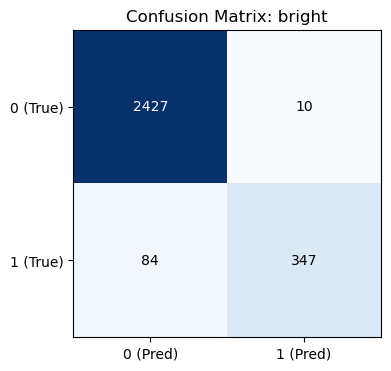

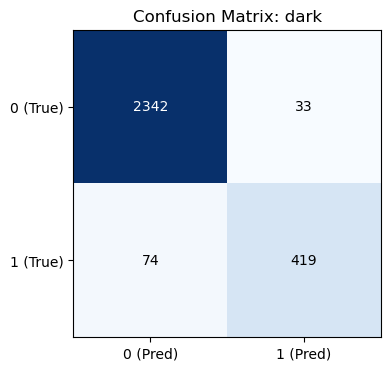

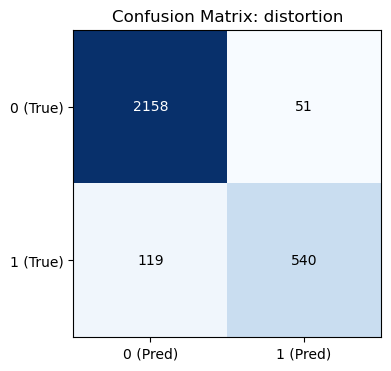

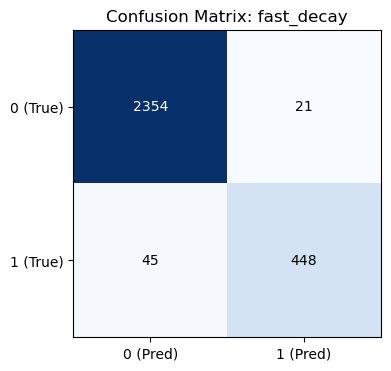

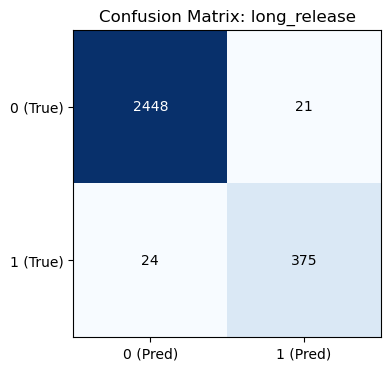

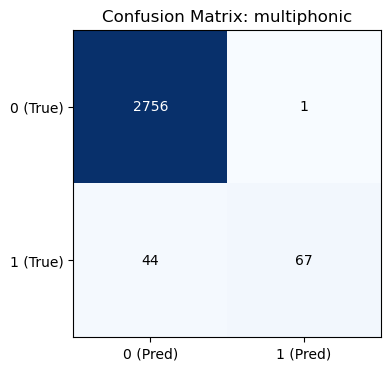

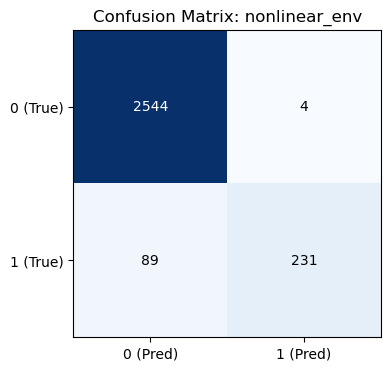

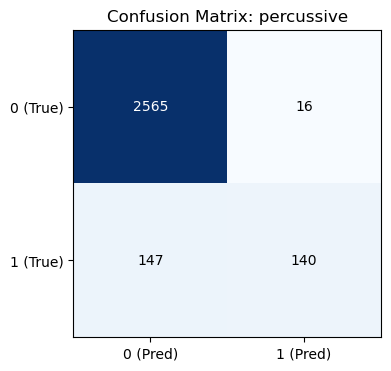

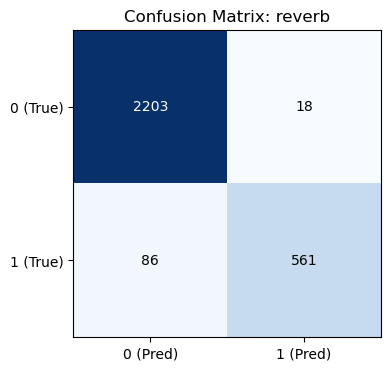

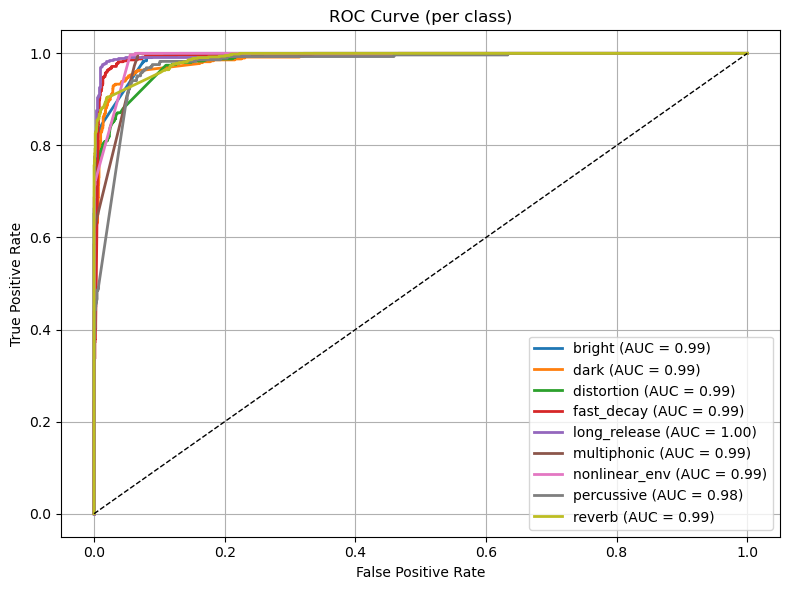


 Classification Report (per class):
               precision    recall  f1-score   support

       bright     0.9720    0.8051    0.8807       431
         dark     0.9270    0.8499    0.8868       493
   distortion     0.9137    0.8194    0.8640       659
   fast_decay     0.9552    0.9087    0.9314       493
 long_release     0.9470    0.9398    0.9434       399
  multiphonic     0.9853    0.6036    0.7486       111
nonlinear_env     0.9830    0.7219    0.8324       320
   percussive     0.8974    0.4878    0.6321       287
       reverb     0.9689    0.8671    0.9152       647

    micro avg     0.9470    0.8146    0.8758      3840
    macro avg     0.9499    0.7782    0.8483      3840
 weighted avg     0.9467    0.8146    0.8710      3840
  samples avg     0.6721    0.6218    0.6316      3840



In [49]:
plot_multilabel_confusion_matrices(y_test, y_pred_bin, quality_classes)
plot_multilabel_roc(y_test, y_pred_prob, quality_classes)
print_classification_report(y_test, y_pred_bin, quality_classes)


## Conclusion

The model demonstrates strong performance on the test set, with high precision across nearly all classes (mostly above 0.90), indicating that when the model predicts a label, it's usually correct. Labels like bright, fast_decay, long_release, and reverb show particularly strong F1 scores, reflecting both accurate and consistent predictions.

However, recall is lower for some classes—especially multiphonic (60%) and percussive (49%)—suggesting the model often misses these labels when they are actually present. This may be due to class imbalance or subtler acoustic patterns.

Overall metrics like micro F1 = 0.88 and macro F1 = 0.85 confirm good multi-label performance. The samples F1 score (0.63) is lower, indicating that fully predicting all correct labels for each sample remains a challenge, which is common in multi-label tasks.